In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 100,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9691358024691358, Loss: 0.22825716159961842
Checkpoint 200, Accuracy: 0.9753086419753086, Loss: 0.1968745125664605
Checkpoint 300, Accuracy: 0.9753086419753086, Loss: 0.1736469268798828
Checkpoint 400, Accuracy: 0.9814814814814815, Loss: 0.1606581652605975
Checkpoint 500, Accuracy: 0.9814814814814815, Loss: 0.1497059045014558


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9402993  0.00774017 0.05196058]
[0. 1. 0.] <-> [0.08714011 0.91173404 0.00112583]
[1. 0. 0.] <-> [0.9693578  0.00570405 0.02493815]
[1. 0. 0.] <-> [0.9430303  0.04062367 0.01634604]
[1. 0. 0.] <-> [0.9371475  0.00753676 0.05531571]
[1. 0. 0.] <-> [0.9042843  0.00810613 0.08760951]
[1. 0. 0.] <-> [0.5282355  0.01939433 0.45237017]
[1. 0. 0.] <-> [0.9460134  0.00571811 0.04826851]
[1. 0. 0.] <-> [0.9045799  0.00873641 0.08668365]
[1. 0. 0.] <-> [0.95055705 0.03086031 0.01858271]
[0. 1. 0.] <-> [0.5596267  0.42535642 0.01501687]
[0. 0. 1.] <-> [0.07100856 0.01405537 0.91493607]
[1. 0. 0.] <-> [0.8923447  0.09165122 0.01600401]
[1. 0. 0.] <-> [0.5217929  0.4707529  0.00745422]
[1. 0. 0.] <-> [0.95182556 0.02511067 0.02306373]
[0. 0. 1.] <-> [0.06547207 0.01365229 0.92087567]
[1. 0. 0.] <-> [0.9712228  0.01039279 0.01838441]
[1. 0. 0.] <-> [0.9192177  0.01150277 0.06927951]
[1. 0. 0.] <-> [0.96176714 0.00469382 0.03353905]
[1. 0. 0.] <-> [0.76012325 0.01596971 0.22390707]


In [12]:
# Testing Performance

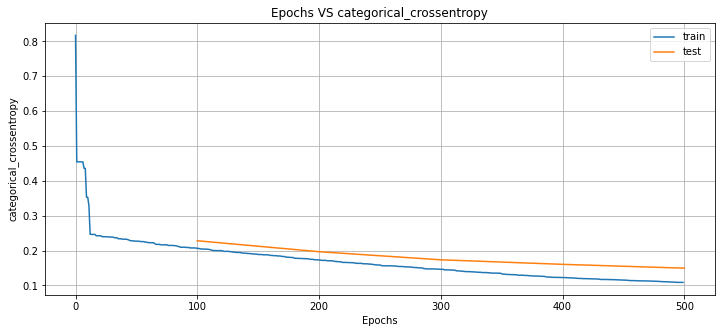

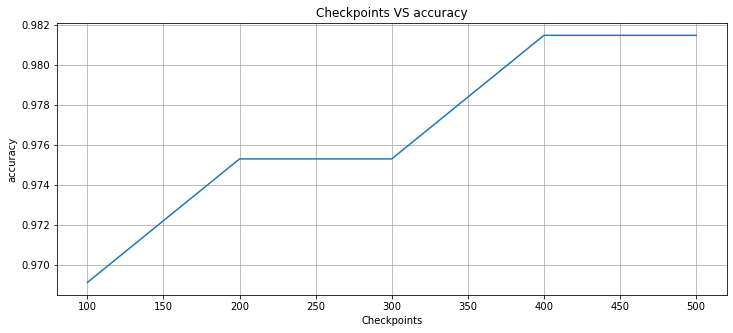

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9691358024691358, 'mean_square_error': 0.11067616704782857, 'categorical_crossentropy': 0.22825716159961842, 'precision': 0.9537037037037037, 'recall': 0.9537037037037037, 'f1': 0.9537037037037037, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 4, 'tn_hit': 24, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9753086419753086, 'mean_square_error': 0.08857849745462468, 'categorical_crossentropy': 0.1968745125664605, 'precision': 0.9629629629629629, 'recall': 0.9629629629629629, 'f1': 0.9629629629629629, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 3, 'tn_hit': 25, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 2}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 1}}, 'checkpoint': 200} 


{'accuracy': 0.9753086419753086, 'mean_square_error': 0.07759019904754821, 'categorical_crossentropy': 0.1736469268798828, 'precisi

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.8443844  -2.7325897  -0.96896327  1.9899311   0.41748992]
 bias: 2.11625075340271

Neuron 1: weights:
[ 0.12334866  1.6413696  -0.40343976 -2.290054   -2.825041  ]
 bias: 1.0199190378189087

Neuron 2: weights:
[-1.4903916   1.5299563  -0.47995317  0.10039084 -0.9313007 ]
 bias: 2.418116331100464

Neuron 3: weights:
[-0.66076756  2.3170717   1.2450901  -1.430981   -2.5468113 ]
 bias: -2.7370479106903076

$
Layer 2
Neuron 0: weights:
[ 2.3321764  1.2458143  1.4044175 -1.8311095]
 bias: -0.3511561453342438

Neuron 1: weights:
[-2.1521893  -1.6851366  -0.22437921  3.        ]
 bias: 2.6358888149261475

Neuron 2: weights:
[ 2.5398655 -2.9953158 -1.3370626 -1.9161615]
 bias: 2.2033472061157227

$

